In [291]:
import praw
import pandas as pd
import re
import string
from collections import Counter
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from matplotlib import pyplot
%matplotlib inline


In [292]:
# get reddit secret & script i've saved as .txt in the working directory

with open('reddit_oa_script.txt') as f:
    
    reddit_script = f.read().strip()
    
with open('reddit_oa_secret.txt') as f:
    
    reddit_secret = f.read().strip()
    
with open('reddit_id.txt') as f:
    
    pw = f.read().strip()

In [293]:
# user_agent is the name of the app

reddit  = praw.Reddit(client_id=reddit_script,
                          client_secret=reddit_secret,
                          user_agent='get_corpora',
                          username='neurodivergent_ai',
                          password=pw)


In [294]:
# get the subreddit

subreddit_1 = reddit.subreddit('The_Donald')

# get the top (upvoted) 1000 threads

subreddit_1_top = subreddit_1.top(limit=1000)

In [295]:
# get the top 5 submissions to check

for post in subreddit_1.top(limit=5):
    
    print(post.title, '\n')

DONALD J. TRUMP DECLARED THE WINNER! 

I’m Donald J. Trump and I'm Your Next President of the United States. 

The New Algorithm Was Designed To Keep President Trump From The Front Page... But Sadly, That Won't Happen. 

CNN will soon be #1...when searching for the term "Fake News". Congratulations to CNN on this major achievement. 

ALL CELEBRITIES THAT VOWED TO LEAVE THE U.S.A. IF TRUMP WINS, WE NOW DEMAND YOU TO FOLLOW THROUGH!!!! OUT! OUT! OUT! 



In [296]:
# build a dataset

# choose information to gather

columns_dict = {'title':[],
               'id':[],
               'url':[],
               'date':[],
               'score':[],
               'num_comments':[],
               'body':[]}

# build a dictionary

for post in subreddit_1_top:
    
    columns_dict['title'].append(post.title)
    
    columns_dict['id'].append(post.id)
    
    columns_dict['url'].append(post.url)
    
    columns_dict['date'].append(post.created)
    
    columns_dict['score'].append(post.score)
    
    columns_dict['num_comments'].append(post.num_comments)
    
    columns_dict['body'].append(post.selftext)

# convert dictionary to a dataframe

subreddit_1_df = pd.DataFrame(columns_dict)


In [297]:
subreddit_1_df.head()

,title,id,url,date,score,num_comments,body
0,DONALD J. TRUMP DECLARED THE WINNER!,5bzjv5,https://www.reddit.com/r/The_Donald/comments/5...,1.478706e+09,66714,12093,#Meme Magic is REAL.\n\n#Donald J. Trump is th...
1,I’m Donald J. Trump and I'm Your Next Presiden...,4uxdbn,https://www.reddit.com/r/The_Donald/comments/4...,1.469687e+09,42127,20800,Hello The_Donald readers and the entire Reddit...
2,The New Algorithm Was Designed To Keep Preside...,5gvy1j,https://i.sli.mg/gu0oHA.png,1.481092e+09,40964,832,
3,CNN will soon be #1...when searching for the t...,5jt9xs,https://i.redd.it/7jeyhzgku65y.png,1.482472e+09,37282,724,
4,ALL CELEBRITIES THAT VOWED TO LEAVE THE U.S.A....,5bz5ds,https://www.reddit.com/r/The_Donald/comments/5...,1.478702e+09,36625,1685,Now that we have proven our commitment to the ...


In [298]:
# create a copy to work on

reddit_df = subreddit_1_df.copy()

In [299]:
# grab texts to build into corpus

titles_df = reddit_df['title']

posts_df = reddit_df['body']

In [300]:
titles_df.head(10)

0                 DONALD J. TRUMP DECLARED THE WINNER!
1    I’m Donald J. Trump and I'm Your Next Presiden...
2    The New Algorithm Was Designed To Keep Preside...
3    CNN will soon be #1...when searching for the t...
4    ALL CELEBRITIES THAT VOWED TO LEAVE THE U.S.A....
5                             IMMINENT VICTORY THREAD.
6    Hey admins, we found a picture of your wife's ...
7             Oh yeah, nothing fucky going on here :^)
8                     Can't Stump your President Trump
9    It's official: Trump will become the first U.S...
Name: title, dtype: object

In [301]:
posts_df.head(10)

0    #Meme Magic is REAL.\n\n#Donald J. Trump is th...
1    Hello The_Donald readers and the entire Reddit...
2                                                     
3                                                     
4    Now that we have proven our commitment to the ...
5    #THIS IS NOT A DRILL. WE ARE ACTUALLY GOING TO...
6                                                     
7                                                     
8                                                     
9                                                     
Name: body, dtype: object

In [302]:
# experiment
# need to toeknize, etc

text = posts_df[4].split()

print(text)

['Now', 'that', 'we', 'have', 'proven', 'our', 'commitment', 'to', 'the', 'cause,', 'now', 'that', 'we', 'have', 'voiced', 'and', 'acted', 'on', 'our', 'patriotism,', 'now', 'that', 'against', 'all', 'odds', 'and', 'constant', 'criticism', 'with', 'the', 'world', 'against', 'us,', 'we', 'have', 'won,', 'and', 'we', 'call', 'for', 'this:', '#All', 'of', 'you', 'elitist', 'hollywood', 'celebrities', 'who', 'vowed', 'to', 'betray', 'your', 'country', 'and', 'leave,', 'to', 'abandon', 'and', 'shun', 'those', 'who', 'you', 'spent', 'your', 'careers', 'milking', 'for', 'your', 'posh', 'lifestyles,', 'we', 'ask,', 'nay,', 'demand', 'that', 'you', 'follow', 'through', 'on', 'your', 'claims', 'to', 'leave', 'the', 'country.', 'We', 'as', 'Americans', 'have', 'spoken,', 'and', 'you', 'brushed', 'us', 'and', 'our', 'movement', 'off,', 'as', 'if', 'you', 'were', 'somehow', 'above', 'us,', 'forgetting', 'that', 'it', 'was', 'us', 'who', 'made', 'you.', '**FUCK', 'YOU!**', 'You', 'think', 'you', 'ar

on the first go around, i'm going to try a lean text preparation strategy for ease of training. what i mean by this is that i'm removing comparatively a lot for a word embedding (but less than classical nlp text prep for many tasks). 

i'll add more features in one at a time later, to see how it affects performance. this means that for now, the text needs to be cleaned. 

lots of stopwords, punctuation, & non-alpha characters. case needs to be lowered etc.

In [303]:
def clean_text(doc):
    '''
    tokenizes input text, converts to lowercase,
    removes punctuation/non-alphabetic characters
    and stopwords. returns clean document.
    
    '''
    
    # tokenize
    
    split_tokens = doc.split()
    
    # grab punctuation list
    
    punctuation = string.punctuation
    
    # set up regex 
    
    punct_filter = re.compile('[%s]' % re.escape(punctuation))
    
    # filter out punctuation
    
    no_punct_tokens = [punct_filter.sub('', char) for char in split_tokens]
    
    # remove non-alphabetic tokens
    
    alpha_tokens = [t for t in no_punct_tokens if t.isalpha()]
    
    # lowercase
    
    lower_tokens = [t.lower() for t in alpha_tokens]
    
    # get stop words
    
    stop_words = set(stopwords.words('english'))
    
    # filter out stopwords
    
    go_tokens = [t for t in lower_tokens if not t in stop_words]
    
    # remove very short tokens
    
    clean_tokens = [word for word in go_tokens if len(word) > 1]
    
    return clean_tokens
    

In [304]:
# test

raw_text = posts_df[4]

clean_text(raw_text)

['proven',
 'commitment',
 'cause',
 'voiced',
 'acted',
 'patriotism',
 'odds',
 'constant',
 'criticism',
 'world',
 'us',
 'call',
 'elitist',
 'hollywood',
 'celebrities',
 'vowed',
 'betray',
 'country',
 'leave',
 'abandon',
 'shun',
 'spent',
 'careers',
 'milking',
 'posh',
 'lifestyles',
 'ask',
 'nay',
 'demand',
 'follow',
 'claims',
 'leave',
 'country',
 'americans',
 'spoken',
 'brushed',
 'us',
 'movement',
 'somehow',
 'us',
 'forgetting',
 'us',
 'made',
 'fuck',
 'think',
 'good',
 'us',
 'well',
 'good',
 'follow',
 'vapid',
 'empty',
 'threat',
 'mistakenly',
 'pridefully',
 'consider',
 'get',
 'fuck',
 'fame',
 'celebrity',
 'status',
 'despicable',
 'shall',
 'say',
 'deplorable',
 'better',
 'us',
 'important',
 'us',
 'would',
 'nothing',
 'without',
 'us',
 'dare',
 'pretend',
 'us',
 'list',
 'demand',
 'leave',
 'asap',
 'amy',
 'unfunny',
 'schumer',
 'lena',
 'dunham',
 'barbra',
 'streisand',
 'bryan',
 'cranston',
 'miley',
 'cyrus',
 'amy',
 'schumer',


In [305]:
def clean_all_texts(texts):
    '''
    iterate through a list of texts
    apply clean_text() function to each
    append each clean text to a list
    return the list of cleaned texts
    
    '''
    
    cleaned_texts = []
    
    for text in texts:
        
        text = clean_text(text)
        
        # remove empty lists
        
        if text:
        
            cleaned_texts.append(text)
        
    return cleaned_texts

In [306]:
clean_titles = clean_all_texts(titles_df)

clean_posts = clean_all_texts(posts_df)

In [307]:
# test

print(clean_titles[4])

print('\n')

print(clean_posts[2])

['celebrities', 'vowed', 'leave', 'usa', 'trump', 'wins', 'demand', 'follow']


['proven', 'commitment', 'cause', 'voiced', 'acted', 'patriotism', 'odds', 'constant', 'criticism', 'world', 'us', 'call', 'elitist', 'hollywood', 'celebrities', 'vowed', 'betray', 'country', 'leave', 'abandon', 'shun', 'spent', 'careers', 'milking', 'posh', 'lifestyles', 'ask', 'nay', 'demand', 'follow', 'claims', 'leave', 'country', 'americans', 'spoken', 'brushed', 'us', 'movement', 'somehow', 'us', 'forgetting', 'us', 'made', 'fuck', 'think', 'good', 'us', 'well', 'good', 'follow', 'vapid', 'empty', 'threat', 'mistakenly', 'pridefully', 'consider', 'get', 'fuck', 'fame', 'celebrity', 'status', 'despicable', 'shall', 'say', 'deplorable', 'better', 'us', 'important', 'us', 'would', 'nothing', 'without', 'us', 'dare', 'pretend', 'us', 'list', 'demand', 'leave', 'asap', 'amy', 'unfunny', 'schumer', 'lena', 'dunham', 'barbra', 'streisand', 'bryan', 'cranston', 'miley', 'cyrus', 'amy', 'schumer', 'jon', 'stew

In [308]:
# combine all sentences

docs = clean_titles + clean_posts

In [309]:
counter = 0

for i in docs:
    
    if counter < 25:
        
        print(i, '\n')
        
        counter +=1

['donald', 'trump', 'declared', 'winner'] 

['donald', 'trump', 'im', 'next', 'president', 'united', 'states'] 

['new', 'algorithm', 'designed', 'keep', 'president', 'trump', 'front', 'page', 'sadly', 'wont', 'happen'] 

['cnn', 'soon', 'searching', 'term', 'fake', 'news', 'congratulations', 'cnn', 'major', 'achievement'] 

['celebrities', 'vowed', 'leave', 'usa', 'trump', 'wins', 'demand', 'follow'] 

['imminent', 'victory', 'thread'] 

['hey', 'admins', 'found', 'picture', 'wifes', 'boyfriends', 'president'] 

['oh', 'yeah', 'nothing', 'fucky', 'going'] 

['cant', 'stump', 'president', 'trump'] 

['official', 'trump', 'become', 'first', 'us', 'president', 'support', 'gay', 'marriage', 'starting', 'inauguration', 'day', 'shame', 'reached', 'rall'] 

['fuck', 'reddit', 'admins', 'like', 'redit', 'try', 'much', 'like', 'cant', 'stop', 'portrait', 'getting', 'upvotes', 'deserves'] 

['reddit', 'cuck', 'admins', 'take', 'official', 'portrait', 'president', 'upvoted', 'post', 'reddits', '

In [310]:
# create a dictionary to study vocabulary

vocab_list = []

for sentence in docs:
    
    for word in sentence:
        
        vocab_list.append(word)

counts = Counter(vocab_list)

print(counts)

Counter({'trump': 342, 'us': 154, 'president': 123, 'clinton': 121, 'people': 118, 'reddit': 114, 'like': 102, 'would': 95, 'hillary': 90, 'one': 80, 'donald': 78, 'get': 77, 'post': 66, 'make': 66, 'media': 66, 'campaign': 65, 'going': 61, 'even': 61, 'new': 59, 'time': 59, 'foundation': 58, 'news': 57, 'dont': 57, 'email': 57, 'first': 56, 'hate': 56, 'rall': 54, 'see': 54, 'know': 52, 'support': 50, 'america': 49, 'cnn': 48, 'im': 47, 'admins': 47, 'dnc': 47, 'many': 46, 'right': 44, 'want': 43, 'election': 43, 'also': 43, 'never': 42, 'year': 41, 'crime': 40, 'left': 39, 'breaking': 39, 'made': 39, 'political': 39, 'well': 39, 'say': 38, 'every': 37, 'today': 37, 'top': 37, 'rthedonald': 37, 'back': 37, 'americans': 37, 'go': 37, 'years': 36, 'edit': 36, 'think': 36, 'state': 35, 'country': 35, 'still': 34, 'need': 34, 'vote': 34, 'wikileaks': 34, 'last': 34, 'lets': 33, 'said': 33, 'black': 33, 'nbsp': 33, 'fake': 32, 'show': 32, 'could': 32, 'got': 32, 'keep': 31, 'man': 31, 'fbi

In [311]:
counts_df = pd.DataFrame.from_dict(counts, orient='index')

counts_df

,0
donald,78
trump,342
declared,4
winner,5
im,47
next,18
president,123
united,17
states,23
new,59


In [312]:
tokens_count = 0

for sentence in docs:
    
    for word in sentence:
        
        tokens_count += 1
        
print(tokens_count)

23418


there are __23,418 total tokens__ and __6,481 unique words__ in this corpus.

not all of these are words--there are a fair amount of slang words, colloquialisms and misspellings included.

In [313]:
# get vocabulary sorted by frequency
# compare words with similar frequencies
# dataframe is counts_df

sorted_docs = counts_df.sort_values(by=[0], ascending=False)

# index

vocab_df = sorted_docs.reset_index()

In [314]:
vocab_df.head(25)

,index,0
0,trump,342
1,us,154
2,president,123
3,clinton,121
4,people,118
5,reddit,114
6,like,102
7,would,95
8,hillary,90
9,one,80


In [315]:
# train word2vec model

w2v_model = Word2Vec(docs, min_count=1)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


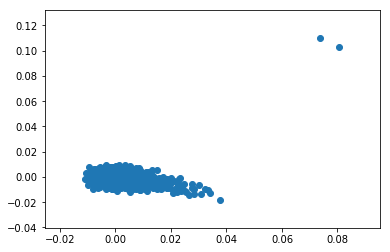

In [316]:
# fit PCA 2d projection to vectors

vector_vocab = w2v_model[w2v_model.wv.vocab]

pca_model = PCA(n_components=2)

pca2d_projection = pca_model.fit_transform(vector_vocab)

# scatterplot the projection

pyplot.scatter(pca2d_projection[:, 0], pca2d_projection[:, 1])

vocab = list(w2v_model.wv.vocab)

#for i, word in enumerate(vocab):
    
    #pyplot.annotate(word, xy=(pca2d_projection[i, 0], pca2d_projection[i, 1]))

In [317]:
# model name: w2v_model

sim = w2v_model.wv.similarity('donald', 'monica')

print(sim)

-0.032839616153229306


In [318]:
sim_1a = w2v_model.wv.similarity('trump', 'people')

sim_1b = w2v_model.wv.similarity('clinton', 'people')

print('distance between trump/people: ', sim_1a)
print('distance between clinton/people: ', sim_1b)

distance between trump/people:  0.5875919552899074
distance between clinton/people:  0.5889439523135688


In [319]:
sim_2a = w2v_model.wv.similarity('man', 'president')

sim_2b = w2v_model.wv.similarity('woman', 'president')

print('distance between man/president: ', sim_2a)
print('distance between woman/president: ', sim_2b)

distance between man/president:  0.2888294228069471
distance between woman/president:  0.15286756552174438


#### but what about her emails?

*email* is in the top 25 words in this vocabulary.

how does the word *email* relate to each candidate? how does it relate to words with strong sentiment?

In [320]:
sim_3a = w2v_model.wv.similarity('email', 'clinton')

sim_3b = w2v_model.wv.similarity('email', 'trump')

sim_3c = w2v_model.wv.similarity('email', 'president')

sim_3d = w2v_model.wv.similarity('email', 'scandal')

sim_3e = w2v_model.wv.similarity('email', 'evil')

print('email/clinton: ', sim_3a)
print('email/trump: ', sim_3b)
print('\n')
print('email/president: ', sim_3c)
print('email/scandal: ', sim_3d)
print('email/evil: ', sim_3e)

email/clinton:  0.4087012535159936
email/trump:  0.30931197313540715


email/president:  0.3558152846234112
email/scandal:  0.014792070171004666
email/evil:  -0.08652820186652159


In [330]:
def get_cos_sim(model, word_1, word_2):
    '''
    pass in 2 words as strings.
    returns cosine similarity of
    the words.
    
    '''
    
    sim = model.wv.similarity(word_1, word_2)
    
    return sim

In [332]:
# test

get_cos_sim(w2v_model, 'trump', 'clinton')

0.5974369505557943

using this method, it's possible to guage attitudes toward each candidate across a number of sentiments.

just to demonstrate, we can choose words that we would expect to have strong associations for this subculture (either positive or negative), *regardless of how frequently they appear in the corpus relative to one another*, without adjusting either the training or vocabulary.

let's use the positive term *qualified* and the negative term *corrupt* from the corpus. we can predict how we would expect this subculture to relate these words to then-candidates trump and clinton. __note__: neither of these words appears very frequently in the corpus.

In [333]:
# get number of occurences for each token from dataframe

clinton = vocab_df[vocab_df['index'] == 'clinton']

trump = vocab_df[vocab_df['index'] == 'trump']

qualified = vocab_df[vocab_df['index'] == 'qualified']

corrupt = vocab_df[vocab_df['index'] == 'corrupt']

print(clinton, '\n')
print(trump, '\n')
print(qualified, '\n')
print(corrupt)

     index    0
3  clinton  121 

   index    0
0  trump  342 

          index  0
5619  qualified  1 

       index  0
564  corrupt  8


In [334]:
# positive associations 

clinton_qualified = get_cos_sim(w2v_model, 'clinton', 'qualified')

trump_qualified = get_cos_sim(w2v_model, 'trump', 'qualified')

# negative associations

clinton_corrupt = get_cos_sim(w2v_model, 'clinton', 'corrupt')

trump_corrupt = get_cos_sim(w2v_model, 'trump', 'corrupt')

print('clinton/qualified: ', clinton_qualified)
print('trump/qualified: ', trump_qualified)
print('clinton/corrupt: ', clinton_corrupt)
print('trump/corrupt', trump_corrupt)

clinton/qualified:  0.04463682576387507
trump/qualified:  0.12479093068188585
clinton/corrupt:  0.13343989039069057
trump/corrupt 0.12338232021240415


of course, the results above should not surprise anyone familiar with the 2016 US presidential election: it is assumed that this particular subculture would view clinton as less qualified (and more corrupt) than trump. what is remarkable is that even on this small (~23,400 total tokens, ~6,400 unique words) corpus, the model was able to pick up on specific semantic relationships like these.

of particular note here is that this shallow model was able to identify sentiment through associations between word pairs where one of the paired words has a few as one occurence.

this is by no means an academically rigorous exercise. however, these preliminary results suggest promise for the potential of shallow word embeddings and cosine similarity measures to probe sociolinguistic relationships among populaces both historic and contemporary--even with relatively small available corpora.


### 'r/esist' subreddit corpus

In [335]:
# get reddit oath credentials for second app

with open('reddit_oa_script_2.txt') as f:
    
    reddit_script_2 = f.read().strip()

with open('reddit_oa_secret_2.txt') as f:
    
    reddit_secret_2 = f.read().strip()

In [336]:
resist_reddit = praw.Reddit(client_id=reddit_script_2,
                           client_secret=reddit_secret_2,
                           user_agent='reddit_corpus_2',
                           username='neurodivergent_ai',
                           password=pw)

In [349]:
# get the subreddit

resist_subreddit = resist_reddit.subreddit('esist')

resist_subreddit_top = resist_subreddit.top(limit=1000)

In [350]:
texts_dict = {'title': [],
              'id': [],
              'url': [],
              'date': [],
              'score': [],
              'body': []}

for post in resist_subreddit_top:
    
    texts_dict['title'].append(post.title)
    
    texts_dict['id'].append(post.id)
    
    texts_dict['url'].append(post.url)
    
    texts_dict['date'].append(post.created)
    
    texts_dict['score'].append(post.score)
    
    texts_dict['body'].append(post.selftext)
    
    #df = pd.DataFrame(texts_dict)
  

In [353]:
subreddit_2_df = pd.DataFrame(texts_dict)

print(subreddit_2_df.head())

                                               title      id  \
0  BREAKING NEWS: Supreme Court finds North Carol...  6cnuag   
1  Trump reveals classified information to Russia...  6bd7e9   
2  In the latest AHCA proposal, Republican lawmak...  67nkkz   
3  Trump says: "We have to start winning wars aga...  5whgbc   
4  Presidential sources: US President Trump calls...  65y04u   

                                                 url          date  score body  
0  https://www.yahoo.com/news/u-supreme-court-tos...  1.495495e+09  47341       
1  https://www.washingtonpost.com/world/national-...  1.494912e+09  44752       
2  https://twitter.com/sarahkliff/status/85706221...  1.493236e+09  43652       
3  http://www.cnn.com/videos/politics/2017/02/27/...  1.488240e+09  43184       
4  https://twitter.com/CNNTURK_ENG/status/8540599...  1.492489e+09  41994       


In [354]:
# make a copy to work with

reddit_df_2 = subreddit_2_df.copy()

In [355]:
titles_df_2 = reddit_df_2['title']

posts_df_2 = reddit_df_2['body']

In [356]:
print(titles_df_2.head())

0    BREAKING NEWS: Supreme Court finds North Carol...
1    Trump reveals classified information to Russia...
2    In the latest AHCA proposal, Republican lawmak...
3    Trump says: "We have to start winning wars aga...
4    Presidential sources: US President Trump calls...
Name: title, dtype: object


In [357]:
print(posts_df_2.head(10))

0                                                     
1                                                     
2                                                     
3                                                     
4                                                     
5                                                     
6    Shaun King never fails to nail it. Props to hi...
7                                                     
8                                                     
9                                                     
Name: body, dtype: object


In [358]:
# produce 'clean' texts using identical procedure
# reddit r/The_Donald section above

clean_titles_2 = clean_all_texts(titles_df_2)

clean_posts_2 = clean_all_texts(posts_df_2)

In [359]:
# check to see if missing rows are gone in posts

count = 0

for post in clean_posts_2:
    
    if count < 5:
        
        print(post, '\n')
        
        count += 1

['shaun', 'king', 'never', 'fails', 'nail', 'props', 'posting', 'fb'] 

['clear', 'admins', 'website', 'plans', 'anything', 'around', 'issue', 'long', 'continue', 'make', 'money', 'td', 'violation', 'many', 'reddit', 'policies', 'time', 'time', 'admins', 'take', 'control', 'situation', 'admins', 'reddit', 'close', 'td', 'subreddits', 'users', 'blatantly', 'violating', 'reddit', 'policy', 'please', 'buy', 'reddit', 'gold'] 

['call', 'ahca', 'trumpcare', 'give', 'gop', 'perfect', 'scapegoat', 'trump', 'presidency', 'implodes', 'cowards', 'party', 'like', 'ryan', 'rubio', 'simply', 'allow', 'absorb', 'damage', 'millions', 'people', 'going', 'lose', 'healthcare', 'die', 'bill', 'needs', 'killed', 'kills', 'anyone', 'gop', 'needs', 'pay', 'modest', 'proposalhttpsenwikipediaorgwikiamodestproposal'] 

['trump', 'invited', 'leader', 'philippines', 'dc', 'supported', 'murdering', 'journalists', 'bragged', 'personally', 'murdering', 'drug', 'addicts', 'edit', 'clear', 'yes', 'although', 'murder

In [360]:
# combine all sentences

docs_2 = clean_titles_2 + clean_posts_2

In [361]:
# number of words in cleaned corpus

word_count_2 = 0

for sentence in docs_2:
    
    for word in sentence:
        
        word_count_2 += 1

print(word_count_2)

18130


In [362]:
# number of sentences

print(len(docs_2))

1013


In [364]:
# vocab dictionary with counts

vocab_list_2 = []

for sentence in docs_2:
    
    for word in sentence:
        
        vocab_list_2.append(word)
        
counts_2 = Counter(vocab_list_2)

print(counts_2)


Counter({'trump': 610, 'us': 100, 'people': 94, 'president': 91, 'white': 81, 'tax': 75, 'donald': 75, 'trumps': 74, 'russian': 69, 'would': 69, 'house': 68, 'million': 65, 'gop': 62, 'news': 60, 'republican': 56, 'campaign': 55, 'new': 55, 'republicans': 51, 'election': 49, 'says': 48, 'get': 48, 'know': 44, 'one': 43, 'said': 43, 'russia': 42, 'like': 42, 'fox': 41, 'day': 39, 'america': 37, 'even': 35, 'years': 35, 'dont': 34, 'fbi': 34, 'times': 33, 'make': 33, 'vote': 32, 'time': 31, 'money': 31, 'first': 30, 'party': 29, 'right': 29, 'administration': 28, 'obama': 28, 'guy': 28, 'also': 28, 'bill': 28, 'media': 28, 'congress': 27, 'paul': 27, 'office': 27, 'every': 27, 'cnn': 27, 'call': 26, 'american': 26, 'property': 26, 'want': 25, 'post': 25, 'americans': 25, 'political': 25, 'court': 24, 'putin': 24, 'states': 24, 'state': 24, 'mueller': 24, 'investigation': 24, 'much': 24, 'history': 24, 'former': 23, 'children': 23, 'national': 23, 'nothing': 22, 'hes': 22, 'anything': 22,

In [365]:
# vocab dataframe

counts_df_2 = pd.DataFrame.from_dict(counts_2, orient='index')

sorted_docs_2 = counts_df_2.sort_values(by=[0], ascending=False)

vocab_df_2 = sorted_docs_2.reset_index()

vocab_df_2.head(25)

,index,0
0,trump,610
1,us,100
2,people,94
3,president,91
4,white,81
5,donald,75
6,tax,75
7,trumps,74
8,russian,69
9,would,69


here once again we have two objects to work with: 

* a set of *sentences* from the 'r/esist' subreddit top 1000 posts: `docs_2`
* a dataframe containing the (trimmed) vocabulary, with occurrences: `vocab_df_2`

In [366]:
# train word2vec model

w2v_model_2 = Word2Vec(docs_2, min_count=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


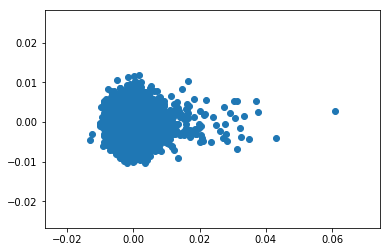

In [367]:
# PCA model

vector_vocab_2 = w2v_model_2[w2v_model_2.wv.vocab]

pca_model_2 = PCA(n_components=2)

pca2d_projection_2 = pca_model_2.fit_transform(vector_vocab_2)

# plot

pyplot.scatter(pca2d_projection_2[:, 0], pca2d_projection_2[:, 1])

In [368]:
# TODO

# grab outliers (specific words)

# both graphs

In [369]:
# grab frequencies for words tested on w2v_model_1

corrupt_2 = vocab_df_2[vocab_df_2['index'] == 'corrupt']

clinton_2 = vocab_df_2[vocab_df_2['index'] == 'clinton']

trump_2 = vocab_df_2[vocab_df_2['index'] == 'trump']

qualified_2 = vocab_df_2[vocab_df_2['index'] == 'qualified']

print(clinton_2, '\n')
print(trump_2, '\n')
print(qualified_2, '\n')
print(corrupt_2)

       index   0
169  clinton  15 

   index    0
0  trump  610 

          index  0
1172  qualified  3 

       index   0
334  corrupt  10


In [371]:
clinton_qualified_2 = get_cos_sim(w2v_model_2, 'clinton', 'qualified')

trump_qualified_2 = get_cos_sim(w2v_model_2, 'trump', 'qualified')

clinton_corrupt_2 = get_cos_sim(w2v_model_2, 'clinton', 'corrupt')

trump_corrupt_2 = get_cos_sim(w2v_model_2, 'trump', 'corrupt')

print('clinton/qualified: ', clinton_qualified_2)
print('trump/qualified: ', trump_qualified_2)
print('clinton/corrupt: ', clinton_corrupt_2)
print('trump/corrupt: ', trump_corrupt_2)


clinton/qualified:  0.04872754364434699
trump/qualified:  0.14960230610741754
clinton/corrupt:  0.14745500351954605
trump/corrupt:  0.23179113354216466


In [372]:
clinton_people_2 = get_cos_sim(w2v_model_2, 'clinton', 'people')

trump_people_2 = get_cos_sim(w2v_model_2, 'trump', 'people')

print(clinton_people_2, trump_people_2)

0.32327930945652383 0.6975644384734749


In [382]:
trump_good = get_cos_sim(w2v_model_2, 'trump', 'good')

trump_evil = get_cos_sim(w2v_model_2, 'trump', 'evil')

clinton_good = get_cos_sim(w2v_model_2, 'clinton', 'good')

clinton_evil = get_cos_sim(w2v_model_2, 'clinton', 'evil')


print(trump_good, trump_evil)
print(clinton_good, clinton_evil)

0.146874127566671 0.14135292368843208
0.09640593193430641 0.18479357039705024


In [374]:
white_good = get_cos_sim(w2v_model_2, 'white', 'good')

white_bad = get_cos_sim(w2v_model_2, 'white', 'bad')

white_evil = get_cos_sim(w2v_model_2, 'white', 'evil')

print(white_good, white_bad, white_evil)

0.14324914861553117 0.05352054677093945 0.08645523250889825


In [379]:
trump_racist = get_cos_sim(w2v_model_2, 'trump', 'racist')

clinton_racist = get_cos_sim(w2v_model_2, 'clinton', 'racist')

white_racist = get_cos_sim(w2v_model_2, 'white', 'racist')

print(trump_racist)
print(clinton_racist)
print(white_racist)

0.23455754262348627
0.11695715956767916
0.24667814126165113


In [381]:
russia_gop = get_cos_sim(w2v_model_2, 'russia', 'gop')

russia_trump = get_cos_sim(w2v_model_2, 'russia', 'trump')

russia_clinton = get_cos_sim(w2v_model_2, 'russia', 'clinton')

print(russia_gop)
print(russia_trump)
print(russia_clinton)

0.45221955284150434
0.4623689454102031
0.1655967198447354
